In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
%matplotlib inline


In [37]:
plt.rcParams['axes.grid'] = True   # Default behaviour for all graphs. 

**Load data**

In [38]:
telecom_data = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col= "customerID")

*Define a function to return an easily readable mutual_info_regression.*

In [39]:
def get_mi_score(X: pd.DataFrame, y: pd.Series, discrete_features, random_state = None) -> pd.Series:

    """Returns the mutual information of columns using scikit-learn's mutual_info_regression. 
    The array returned by the functions is converted to a series before it is sorted descendingly. 

    For more info read https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html
    """
    mi_score = mutual_info_regression(X, y, discrete_features= discrete_features, random_state= random_state)
    mi_score = pd.Series(mi_score, name = "MI score", index = X.columns)
    mi_score.sort_values(ascending= False)

    return mi_score

*"Fix" the TotalCharges columns*

In [40]:
# Customers with no tenure have an empty string as their TotalCharges. It should be replaced with the appropriate numerical value.
no_tenure = telecom_data[telecom_data.tenure == 0]   

total_charges_filled = telecom_data[telecom_data.index.isin(no_tenure.index)].copy()  # select from the original dataframe whose index is in the "no_tenure" dataframe.
total_charges_filled["TotalCharges"] = total_charges_filled["MonthlyCharges"] * total_charges_filled["tenure"]

telecom_data.update(total_charges_filled)
telecom_data["TotalCharges"] = telecom_data["TotalCharges"].astype(float)

*Add a columns to sum the types of InternetServices as OnlineServices*

In [41]:
online_services = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
tel_d = telecom_data.copy(deep= True)

for col in online_services: 
    tel_d[col] = tel_d[col].map({"No" : 0, "No internet service": 0, "Yes": 1})

tel_d["OnlineServices"] = tel_d[online_services].sum(axis= 1)
telecom_data["OnlineServices"] = tel_d["OnlineServices"].astype(int)

*Visualize our new OnlineServices column*

<Axes: xlabel='OnlineServices', ylabel='count'>

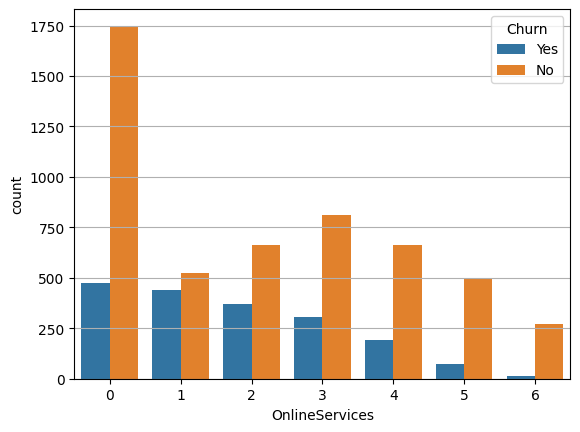

In [42]:
sns.countplot(data = telecom_data, x = "OnlineServices", hue= "Churn")

**EDA**

*KDE to show the relationship between tenure and churn*

<Axes: title={'center': 'Kernel Density Estimate of tenure for Churned vs Unchurned customers'}, xlabel='Tenure (months)', ylabel='Density'>

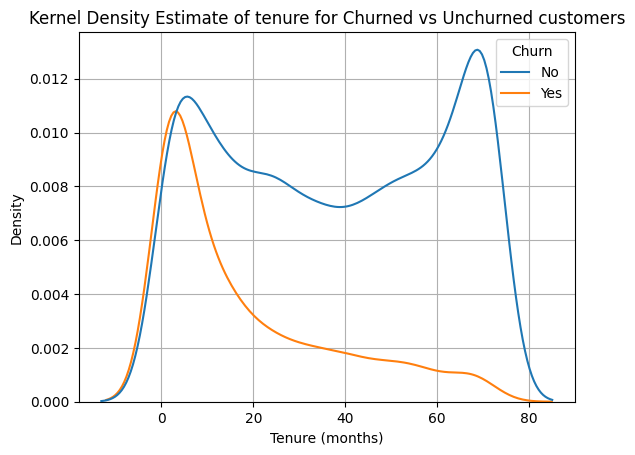

In [43]:
plt.title("Kernel Density Estimate of tenure for Churned vs Unchurned customers")
plt.xlabel("Tenure (months)")
sns.kdeplot(data = telecom_data,  x = "tenure", hue = "Churn", fill = False)

*Illustrate the relationship between contract type and churn*

Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

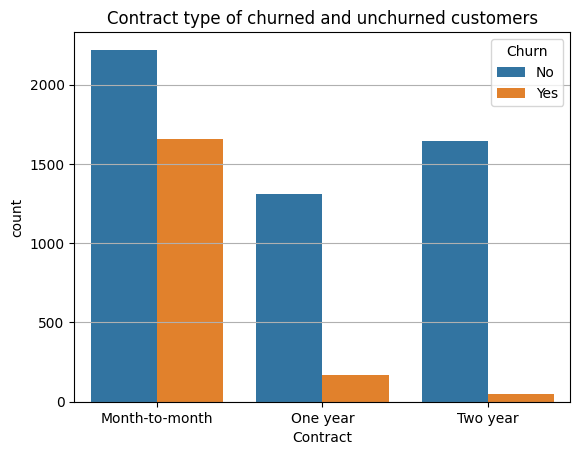

In [44]:
plt.title("Contract type of churned and unchurned customers")
sns.countplot(data = telecom_data, x = "Contract", hue = "Churn")
telecom_data.Contract.value_counts()

*Monthly Charges for churned and unchurned customers*

<Axes: xlabel='Monthly charges', ylabel='Density'>

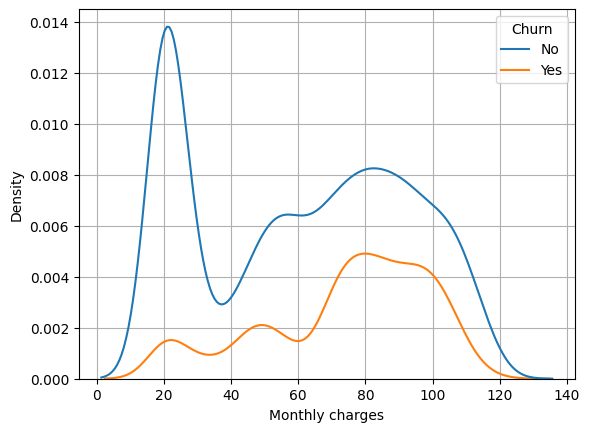

In [45]:
plt.xlabel("Monthly charges")
sns.kdeplot(data = telecom_data, x = "MonthlyCharges", hue = "Churn")

# The plot shows MonthlyCharge isn't, on its own, discriminative enough.  

<Axes: xlabel='Dependents', ylabel='count'>

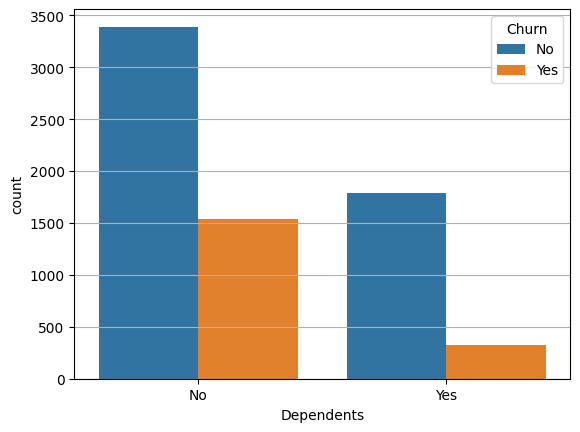

In [46]:
sns.countplot(data = telecom_data, x = "Dependents", hue = "Churn")

In [47]:
y = telecom_data["Churn"].map({"Yes": 1, "No":0})

X = telecom_data.drop("Churn", axis = 1)
X["gender"] = X["gender"].map({"Male": 0, "Female": 1})         # Mapping the gender columns. 0 refers to Male and 1 refers to Female.

closed_columns = ["Partner", "Dependents", "PhoneService"]      # Binary columns with Yes or No values. 
for col in closed_columns:                  # Encode the columns. 0 means No and 1 means Yes. 
    X[col] = X[col].map({"No": 0, "Yes": 1})


*Evaluate the mutual info score of some continuous features*

In [48]:
only_nums_X = X.select_dtypes(include= "number")
num_features = only_nums_X.dtypes == float | int
get_mi_score(only_nums_X, y, discrete_features= num_features, random_state= 1)

gender            0.001977
SeniorCitizen     0.024139
Partner           0.019287
Dependents        0.000258
tenure            0.070347
PhoneService      0.000922
MonthlyCharges    0.050469
TotalCharges      0.043566
OnlineServices    0.018074
Name: MI score, dtype: float64

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 1)
X_train: pd.DataFrame
X_test: pd.DataFrame
y_train: pd.Series
y_test: pd.Series

*Select columns for encoding and encode appropriately*

In [50]:
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_cols = X_train.select_dtypes(include= ["object", "category", "string"]).columns.to_list()

std_scaler = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown= "ignore")

preprocessor = ColumnTransformer(
                                    transformers= [
                                        ("numeric", std_scaler, numerical_cols), 
                                        ("categorical", categorical_transformer, categorical_cols)
                                        ])


*Define, fit and make predictions with the two specified model types.*

In [51]:
logistic_pipeline = Pipeline(
                            steps = [("preprocess", preprocessor), 
                                        ("model", LogisticRegression(random_state= 1))
                                        ])  

log_model = logistic_pipeline.named_steps["model"]    # Extract our logistic regression model for future use.

logistic_pipeline.fit(X_train, y_train)

logistic_proba = logistic_pipeline.predict_proba(X_test)[:, 1]   # Since we don't want to miss churners, we "increase" our recall at the cost of precision 
logistic_pred_adj = (logistic_proba >= 0.4).astype(int)

log_cm = pd.DataFrame(confusion_matrix(y_test, logistic_pred_adj), 
                      index = ["Actual Negative", "Actual Positive"], 
                      columns= ["Predicted Negative", "Predicted Positive"])

log_report = classification_report(y_test, logistic_pred_adj)
log_auc_score = roc_auc_score(y_test, logistic_pred_adj)

print(log_report)

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1061
           1       0.55      0.70      0.62       348

    accuracy                           0.78      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.81      0.78      0.79      1409



In [52]:
xgb_pipeline = Pipeline(steps =[("preprocessor", preprocessor), 
                                                    ("model", XGBClassifier(random_state = 1))
                                                    ])

xgb_model = xgb_pipeline.named_steps["model"]              # Extract our XGBClassifier model for future use. 

xgb_pipeline.fit(X_train, y_train)
xgb_proba = xgb_pipeline.predict_proba(X_test)[:, 1]            # Since we don't want to miss churners, we "increase" our recall at the cost of precision
xgb_pred_adj = (xgb_proba >= 0.4).astype(int)

xgb_cm = pd.DataFrame(confusion_matrix(y_test, xgb_pred_adj), 
                      index = ["Actual Negative", "Actual Positive"], 
                      columns= ["Predicted Negative", "Predicted Positive"])

xgb_report = classification_report(y_test, xgb_pred_adj)
xgb_auc_score = roc_auc_score(y_test, xgb_pred_adj)

print(xgb_report)

              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1061
           1       0.54      0.64      0.58       348

    accuracy                           0.78      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.79      0.78      0.78      1409



As the LogisticRegressor slightly outperforms the XGBClassifier, we shall use that for tasks that involve the SHAP library. 

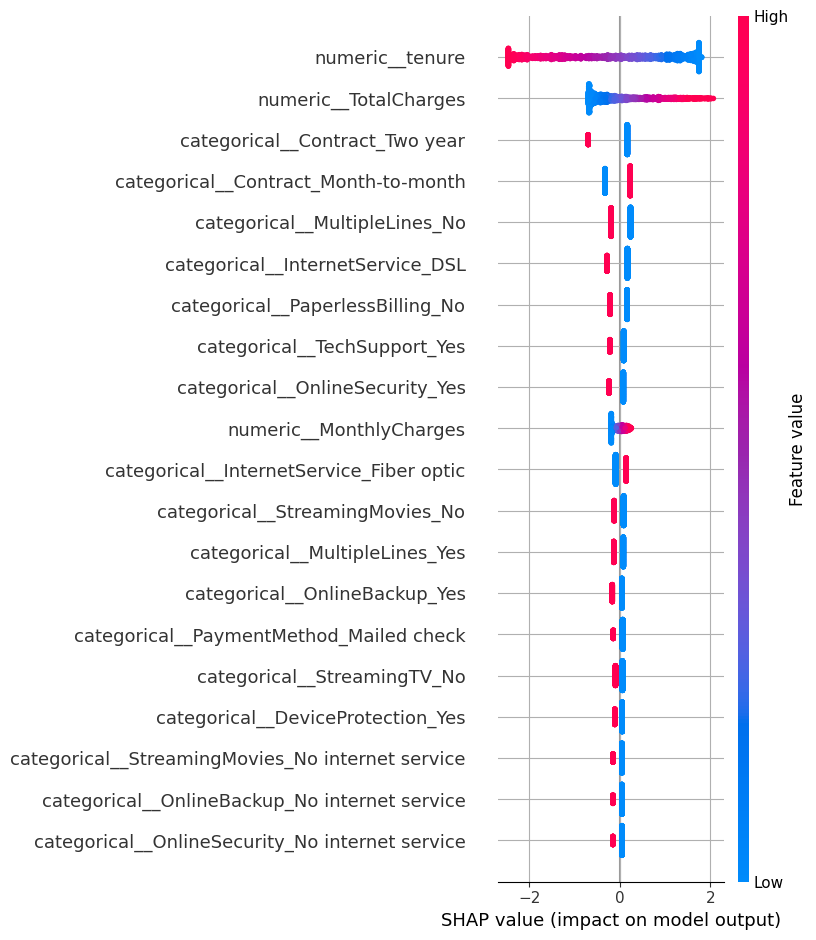

In [53]:
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
feat_names = preprocessor.get_feature_names_out()

masker = shap.utils.sample(X_train_transformed, nsamples= 100, random_state= 1)
explainer = shap.LinearExplainer(model = log_model, masker= masker)

shap_values = explainer(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, feature_names = feat_names,)

The shap summary plot above clearly shows how our model has used features to drive its prediction. Most features are closely centered at 0, meaning they don't contribure much to the prediction. Other columns like MultipleLines and InternetServices offer some predictive potential but three columns stand out.
 
1. **Tenure** : Customers with a higher value for tenure are more likely to stay while newer ones are at risk of churning.

2. **TotalCharges** : Counterintuitively, customers who amassed a larger total charge are susceptible to churn, likely indicating customers who leave after they have amassed a large bill. 

3. **Contract** : Customers with a *two-year* contract are loyal while those with a *Month-to-month* contracts are likely to leave.


For reproducability, sharing, or later model training we shall save a processed version of our original data. The processed version of the original data contains "additional" columns as a result of OneHotEncoding. 

In [63]:
telecom_data_processed = pd.DataFrame(preprocessor.transform(X), index = X.index, columns= feat_names)  #Since the columns of X_processed and X_train_transformed are the same we will use feat_names.
telecom_data_processed["Churn"] = y

telecom_data_processed.reset_index(inplace=True)
telecom_data_processed.to_csv("../data/processed_data.csv", index= False)